# Spam Filter

The objective of this is to create a classifier to distinguish between spam and non-spam (ham) emails.

In [1]:
from glob import glob
import pickle
import sys
print( sys.version )
from IPython.display import clear_output

import random
import collections
from functools import reduce
from itertools import chain, combinations
from operator import methodcaller
from email.parser import Parser
import re
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from sklearn.externals import joblib
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.cluster import KMeans, MiniBatchKMeans

pylab.rcParams['figure.figsize'] = (32.0, 24.0)
pylab.rcParams['font.size'] = 24

3.5.2 |Continuum Analytics, Inc.| (default, Jul  5 2016, 11:41:13) [MSC v.1900 64 bit (AMD64)]


## Loading Data and Preprocessing

The following cell defines two functions, `simplePreprocess` and `getEmails`. 

* The `getEmails` function reads in the emails in a given folder and applies a preprocessing algorithm to convert the raw text into a list of words. 

* The `simplePreprocess` function splits an email by whitespace and filters out non-alphabetical strings.

The motivation for these functions is to allow for more advanced preprocessing techniques in the future.

In [5]:
def simplePreprocess( email ):
    words = [ w.lower() for w in email.split() if w.isalpha() ]
    return reduce( lambda x, y : '%s %s' % (x, y), words, '' )

def getEmails( folder = None, preprocess = lambda x : x ):
    '''
        Given a folder to retrieve from, 
        returns a list where each item is a list of the words in an email
    '''
    if folder:
        files = [*map( open, glob( '%s/*.txt' % folder ) )]
        emails = [ preprocess( f.read() ) for f in files ]
        map( methodcaller('close'), files )
        return emails
    else:
        return getEmails( 'spam' ) + getEmails( 'ham' )

## Analysing Simple Email Features

In [6]:
def probabilities( emails ):
    '''
        Given a list were each item is a list of words,
        returns a dictionary that map words to probabilties
    '''
    words = sum( [ list(set( e.split() )) for e in emails ], [] )
    counter = collections.Counter( words )
    return { k : v / len( emails ) for k, v in counter.items() }

def getMostProbable( dist, n ):
    '''
        Given a probability distribution and a number of instances to get,
        returns the n most probable instances
    '''
    items = list( dist.items() )
    items.sort( key = lambda x : -x[1] )
    return dict( items[ : n ] )

def plotHist( dist, title = '', xlabel = '', ylabel = '', \
              sortkey = lambda x : -x[1], ylim = [], rotation = 45 ):
    '''
        Plots a probablity distribution as a histogram
    '''
    items = list( dist.items() )
    items.sort( key = sortkey )
    author_names = [ k for k, v in items ]
    author_counts = [ v for k, v in items ]

    # Plot histogram using matplotlib bar().
    indexes = np.arange(len(author_names))
    width = 0.7
    
    fig = plt.figure( figsize = (32.0, 7.0) )
    ax = fig.add_subplot( 111 )
    ax.bar( indexes, author_counts, width)
    ax.set_xticks( indexes + width * 0.5 )
    ax.set_xticklabels( author_names, rotation = rotation )
    ax.set_title( title )
    ax.set_xlabel( xlabel )
    ax.set_ylabel( ylabel )
    if ylim:
        ax.set_ylim( ylim )
    plt.show()
    
def histDifference( h1, h2 ):
    '''
        Given two probability distributions,
        returns a new distribution representing a key-wise difference
    '''
    return { k : h1[ k ] - h2[ k ] for k in h1.keys() if k in h2 }

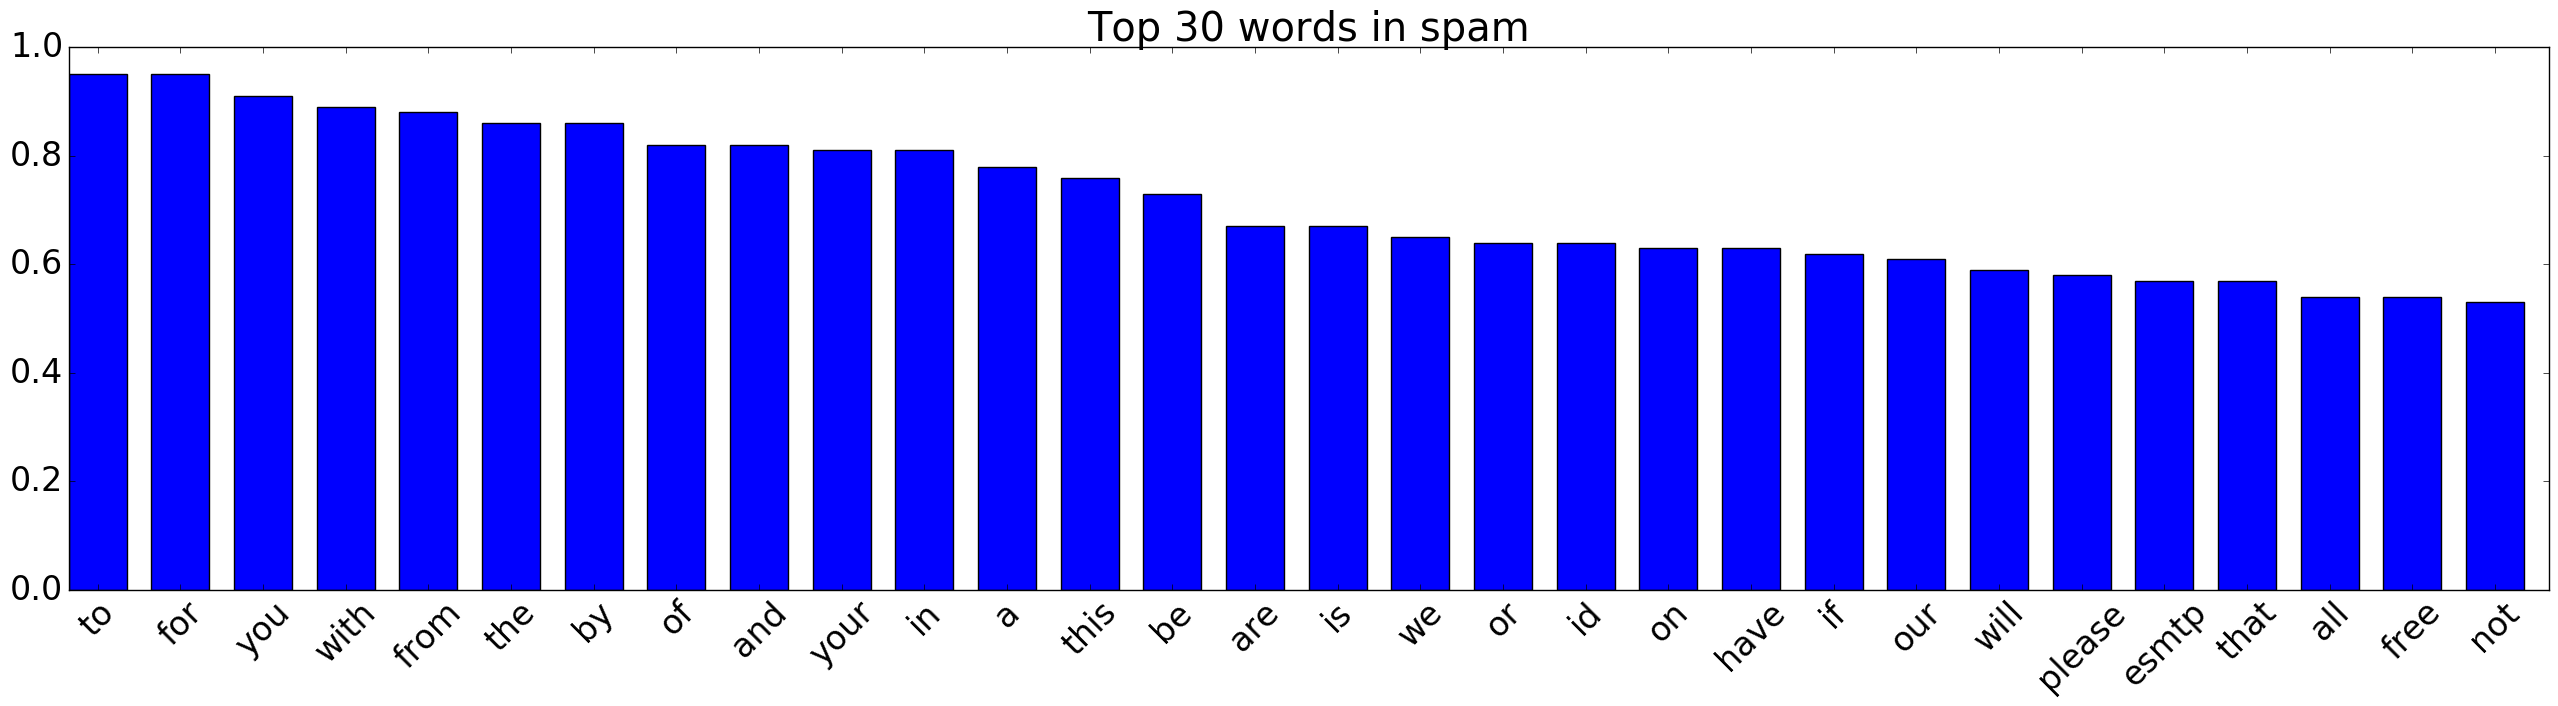

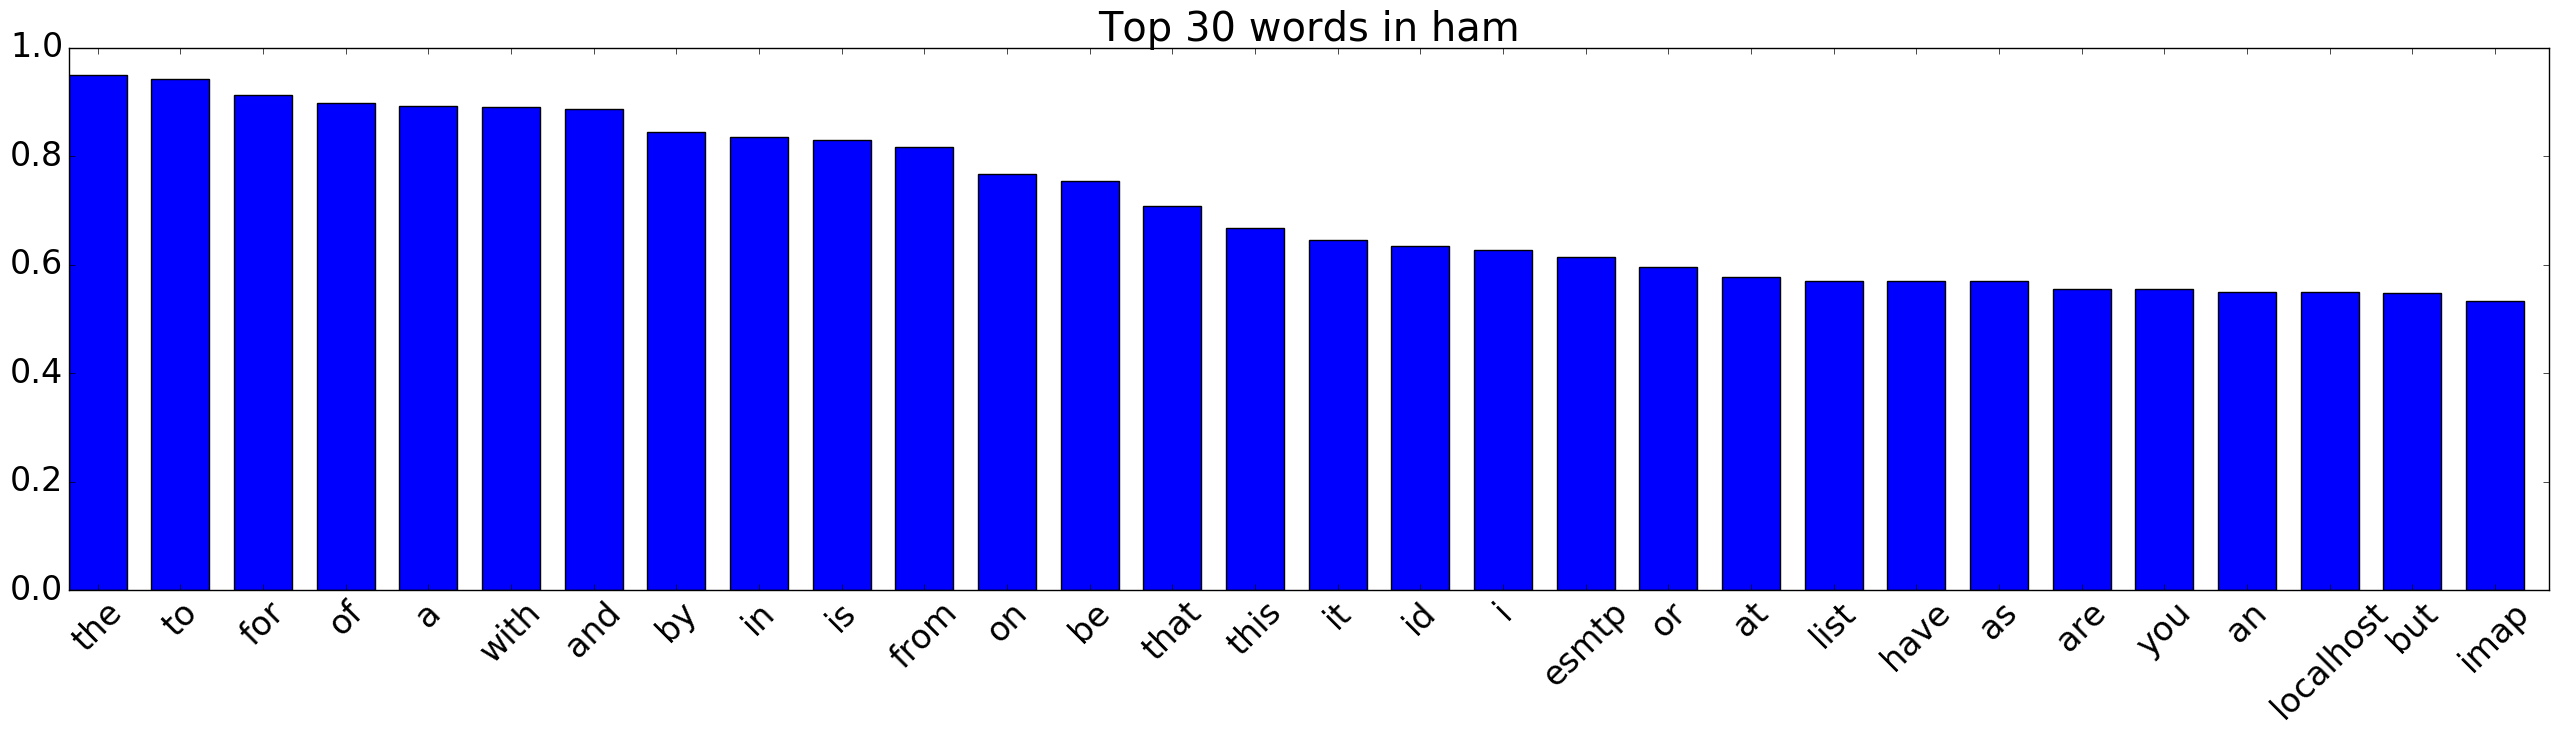

In [738]:
spamProbs = probabilities( getEmails( 'spam', simplePreprocess ) )
hamProbs  = probabilities( getEmails( 'ham', simplePreprocess ) )
plotHist( getMostProbable( spamProbs, 30 ), 'Top 30 words in spam' )
plotHist( getMostProbable( hamProbs, 30 ), 'Top 30 words in ham' )

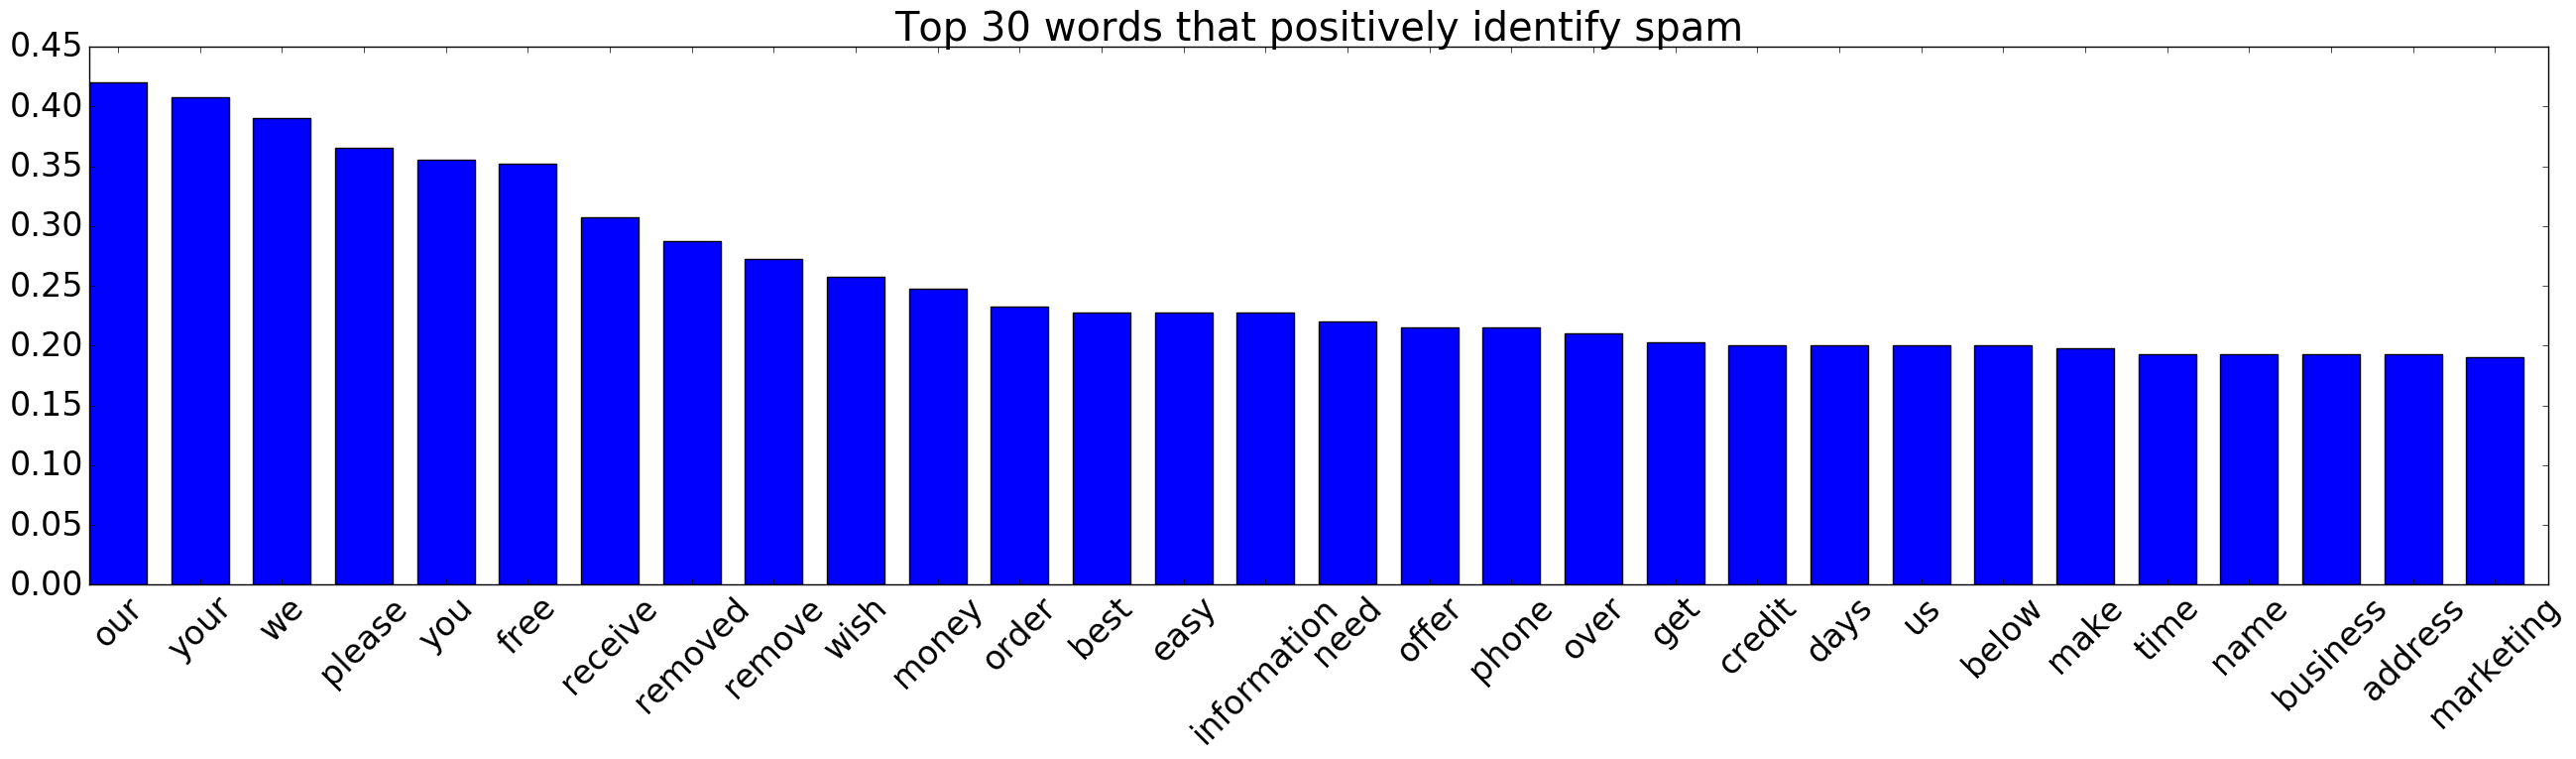

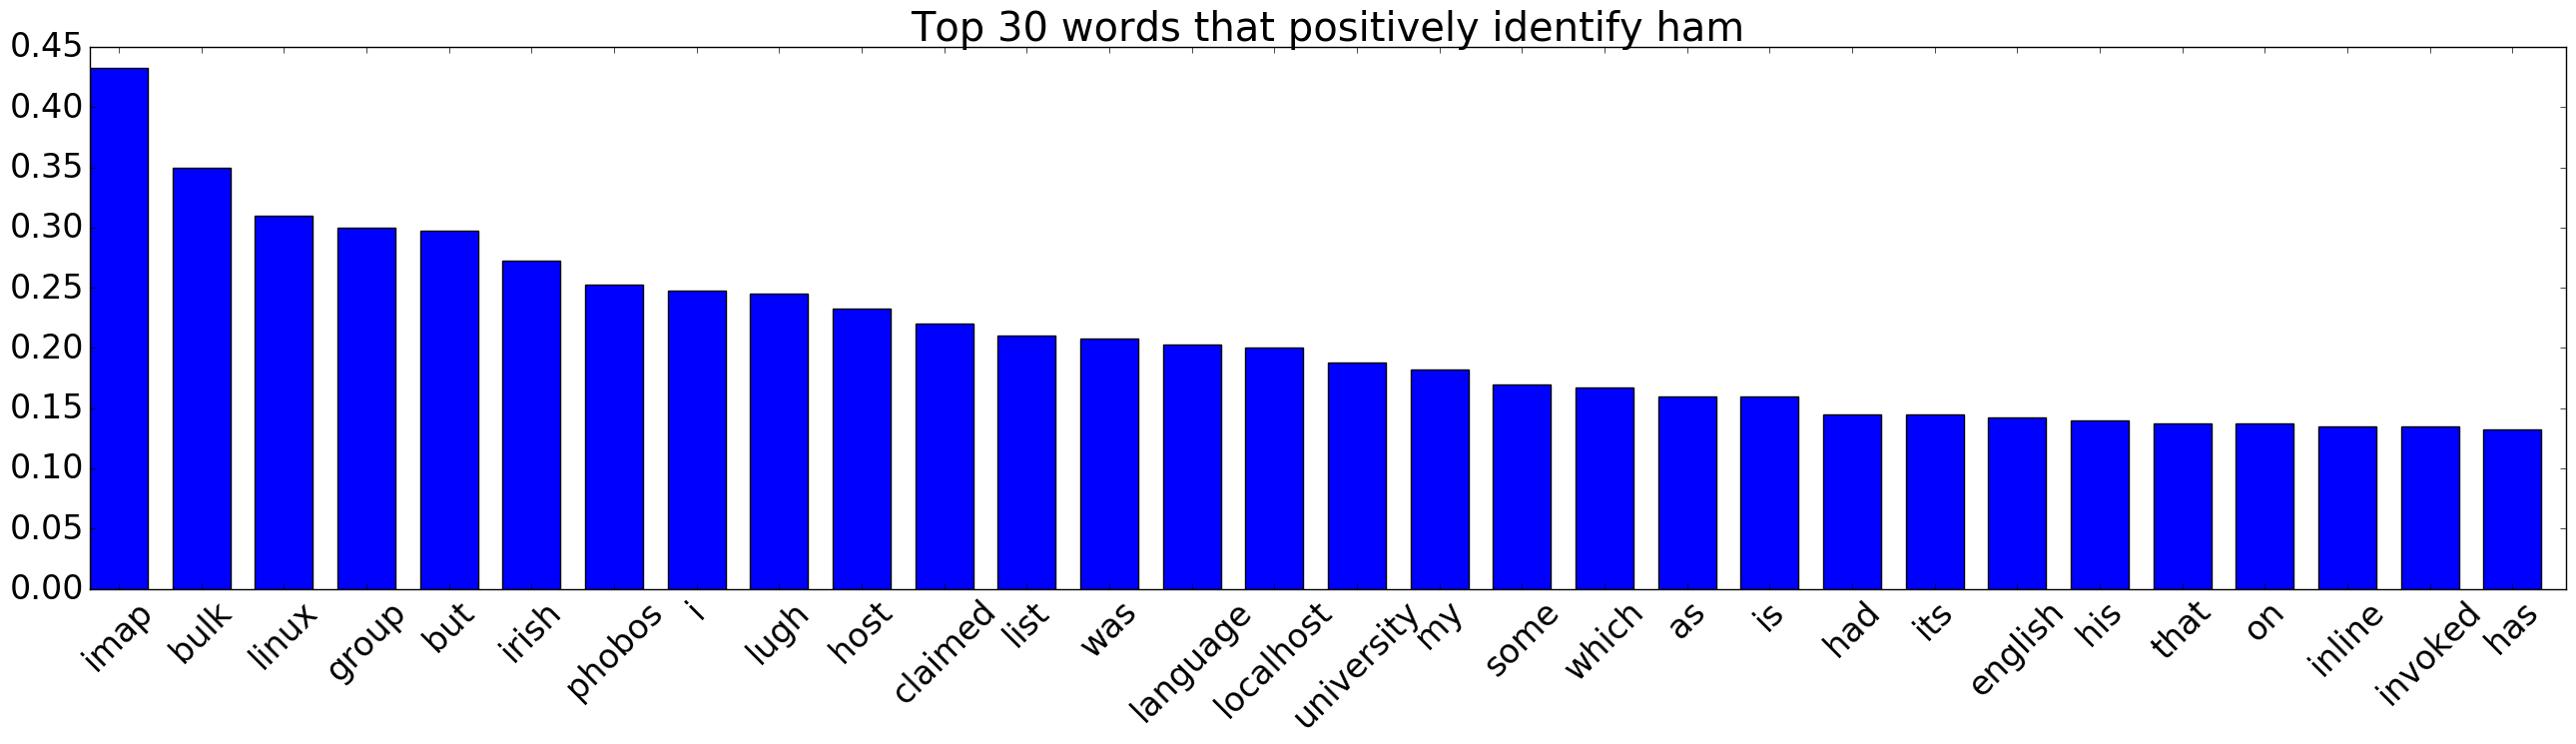

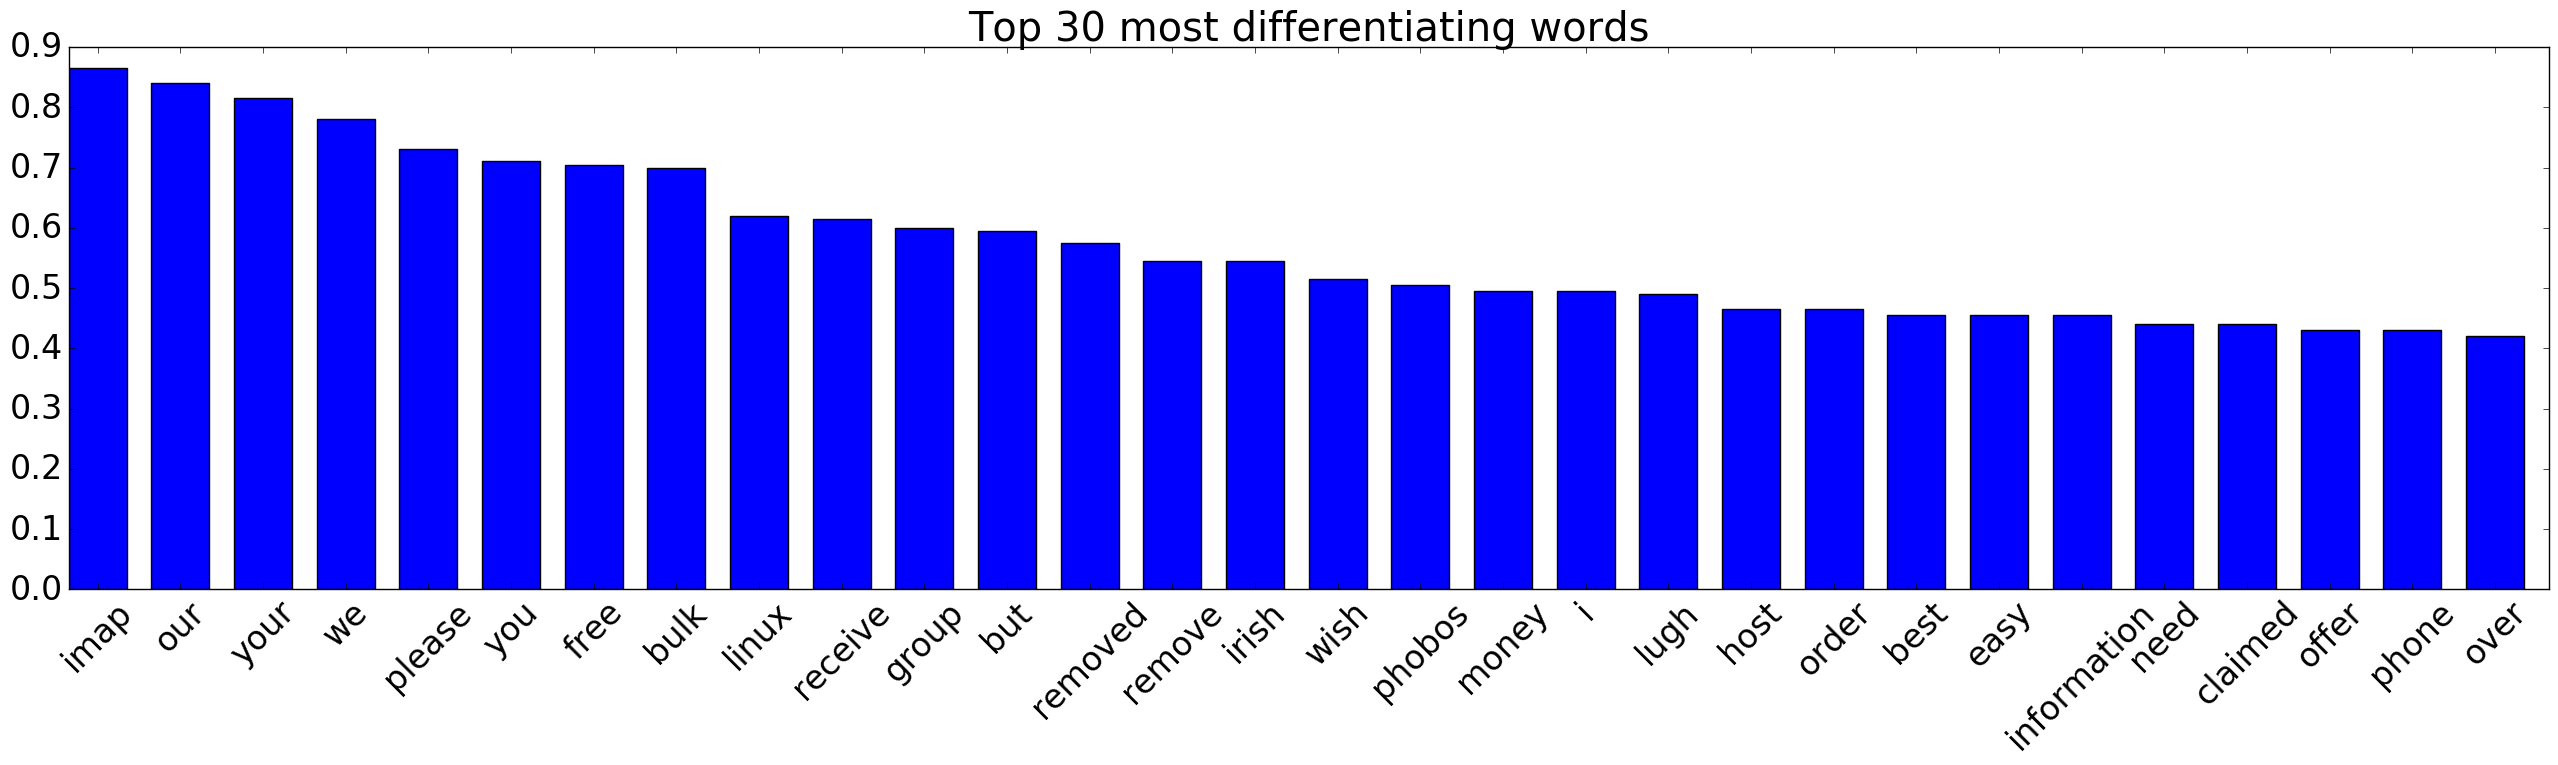

In [7]:
def differenceDistributions( n, preprocess ):
    spamProbs = probabilities( getEmails( 'spam', preprocess ) )
    hamProbs  = probabilities( getEmails( 'ham', preprocess ) )
    spamHamDiff = histDifference( spamProbs, hamProbs )
    hamSpamDiff = histDifference( hamProbs, spamProbs )
    plotHist( getMostProbable( spamHamDiff, n ), 'Top %i words that positively identify spam' % n )
    plotHist( getMostProbable( hamSpamDiff, n ), 'Top %i words that positively identify ham' % n )
    mostIdentifying = dict( ( k, abs( spamHamDiff[k] - hamSpamDiff[k] ) ) for k in chain( hamSpamDiff, spamHamDiff ) )
    plotHist( getMostProbable( mostIdentifying, n ), 'Top %i most differentiating words' % n )
    return mostIdentifying
    
_ = differenceDistributions( 30, simplePreprocess )

## Labelling and Feature Extraction

The `getData` function takes a feature extraction function `featureExtract` as a parameter and a `preprocess` function as a parameter and returns a data matrix and a list of labels. Each row in the data matrix corresponds to an email and each column corresponds to a feature.

The next step is to determine how many of the top most differentiating words to use for feature extraction. The `pickingFeatures` function takes an integer `n` and takes the top `n` most differentiating words and creates a data matrix by checking for the presence of those words in the emails. This is then used to train a `BernoulliNB` classifier and the function then returns the mean 5-fold cross validation score.

In [8]:
def getData( featureExtract, preprocess = simplePreprocess ):
    spamEmails = getEmails( 'spam', preprocess )
    hamEmails = getEmails( 'ham', preprocess )

    X = np.matrix([*map( featureExtract, chain( spamEmails, hamEmails ))])
    y = [ 1 ] * len( spamEmails ) + [ 0 ] * len( hamEmails )
    
    return X, y

def pickingFeatures( n ):
    mostIdentifying = getMostProbable( dict(chain( hamSpamDiff.items(), spamHamDiff.items() )), n )
    featureWords = mostIdentifying.keys()
    X, y = getData( lambda e : [ w in e for w in featureWords ] )
    clf = BernoulliNB()
    return cross_val_score( clf, X, y, cv=5 ).mean()

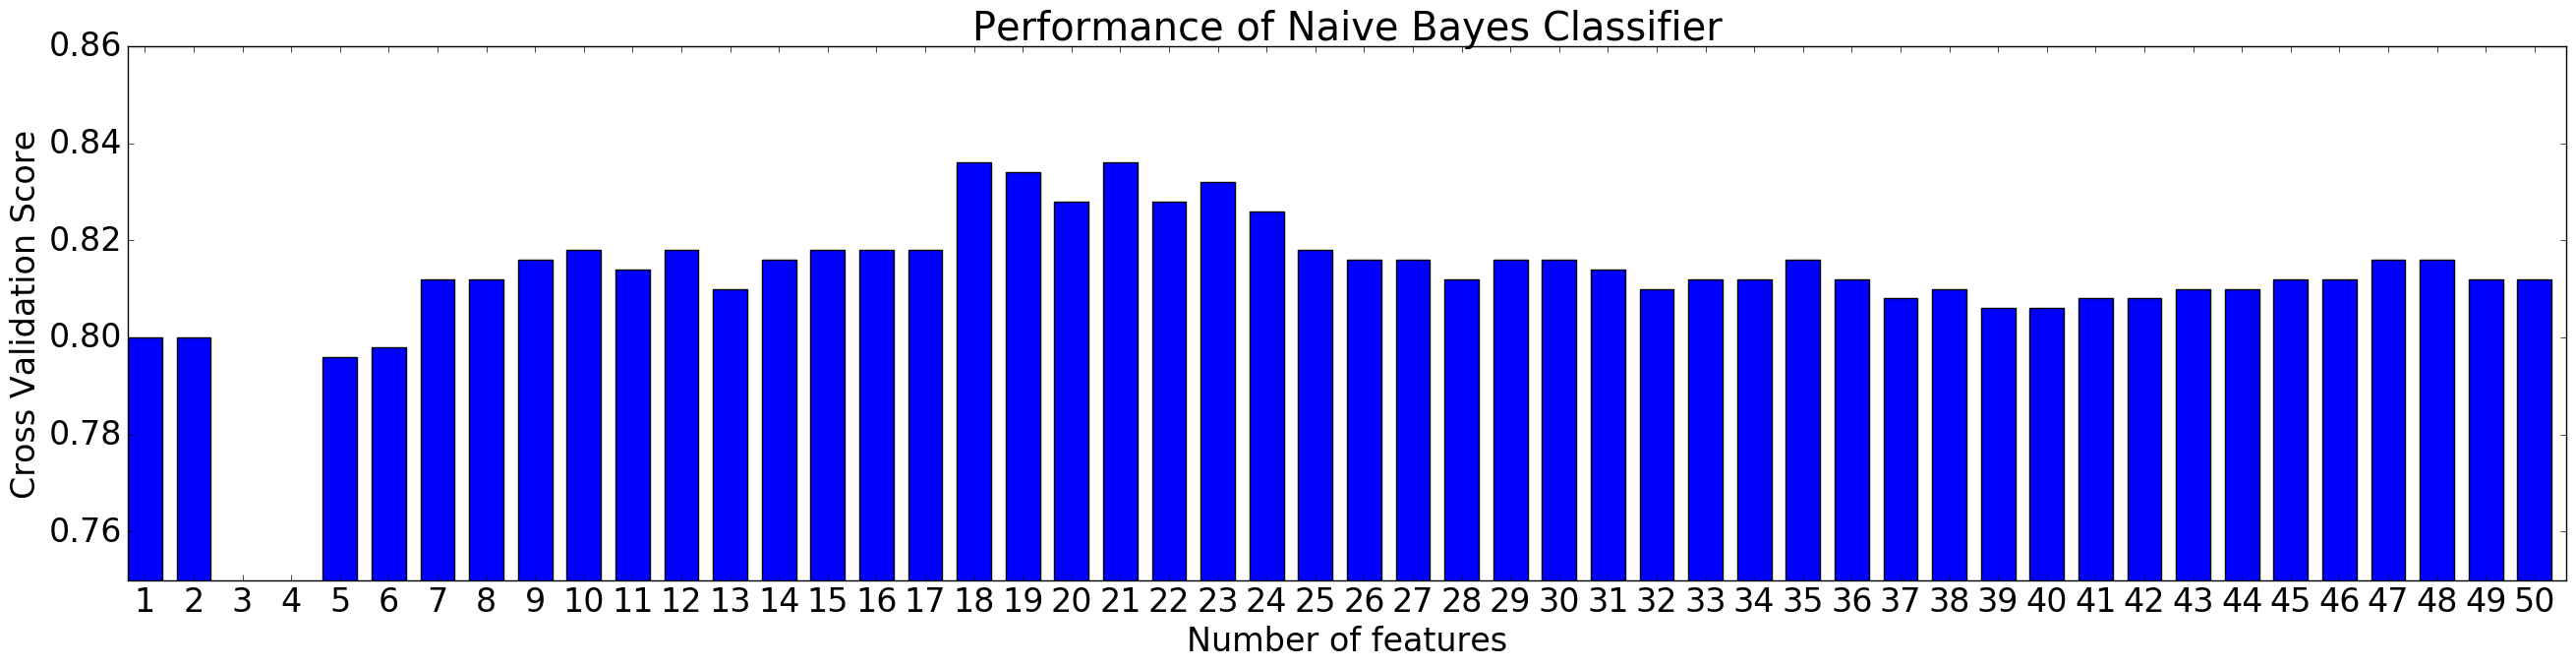

In [751]:
xs = list(range( 1, 51 ))
mapping = { x : pickingFeatures( x ) for x in xs }
plotHist( mapping, title = 'Performance of Naive Bayes Classifier', \
          ylabel = 'Cross Validation Score', xlabel = 'Number of features', \
          sortkey = lambda x : x[0], ylim = [0.75, 0.86], rotation = 0 )

## Creating a Baseline Classifier

In [9]:
mostIdentifying = dict( ( k, max( spamHamDiff[k], hamSpamDiff[k] ) ) for k in chain( hamSpamDiff, spamHamDiff ) )
featureWords = getMostProbable( mostIdentifying, 20 ).keys()

def simpleFeatureExtract( email ):
    return [ w in email for w in featureWords ]

def saveClassifier( clf, filename ):
    joblib.dump( clf, './classifiers/%s.dat' % filename )
    
def loadClassifier( filename ):
    return joblib.load( './classifiers/%s.dat' % filename )

NameError: name 'hamSpamDiff' is not defined

In [767]:
clf = BernoulliNB()
X, y = getData( simpleFeatureExtract, simplePreprocess )
scores = cross_val_score( clf, X, y, cv=5 )
print('Accuracy: %0.3f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))
clf.fit( X, y )
saveClassifier( clf, 'SimpleNaiveBayes' )

Accuracy: 0.846 (+/- 0.06)


In [768]:
clf = MultinomialNB()
X, y = getData( simpleFeatureExtract, simplePreprocess )
scores = cross_val_score( clf, X, y, cv=5 )
print('Accuracy: %0.3f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

Accuracy: 0.858 (+/- 0.06)


## Creating Dummy Classifiers for Comparison

In [18]:
def dummyExtract( email ):
    return [1]

X, y = getData( dummyExtract )
for strategy in [ 'uniform', 'most_frequent' ]:
    dummy_clf = DummyClassifier( strategy = strategy, random_state = 0 )
    dummy_clf.fit( X, y )
    print( 'Accuracy: %0.3f' % dummy_clf.score( X, y ) )

Accuracy: 0.500
Accuracy: 0.800


## More Advanced Preprocessing


So far the preprocessing has been very minimal, the next step will be to separate the content of the emails from the formatting of the emails.

### Subject Lines

The simplest formatting is the subject line of the email, for example in `spam001.txt`:

    Subject: are you serious about your future ?

    the future is here now , and with it comes your opportunity to capitalize on the fastest growing enterprises in history ! electronic commerce on the internet is estimated to grow to $ 327 billion by 2003 . the worldwide market for phone service is projected to be over $ 2 trillion , and deregulation of electric utilities in the us will open up a $ 250 billion market .
    ...

### Further Header Lines

However the subject line is often accompanied by other similar formatting tags, such as `spam008.txt`:

    From Thecashsystem@firemail.de  Thu Aug 22 16:58:24 2002
    Return-Path: <Thecashsystem@firemail.de>
    Delivered-To: zzzz@localhost.spamassassin.taint.org
    Received: from localhost (localhost [127.0.0.1])
        by phobos.labs.spamassassin.taint.org (Postfix) with ESMTP id 3453043F99
        for <zzzz@localhost>; Thu, 22 Aug 2002 11:58:24 -0400 (EDT)
    Received: from mail.webnote.net [193.120.211.219]
        by localhost with POP3 (fetchmail-5.9.0)
        for zzzz@localhost (single-drop); Thu, 22 Aug 2002 16:58:24 +0100 (IST)
    Received: from mailbox-13.st1.spray.net (mailbox-13.st1.spray.net [212.78.202.113])
        by webnote.net (8.9.3/8.9.3) with ESMTP id QAA05573
        for <zzzz@spamassassin.taint.org>; Thu, 22 Aug 2002 16:55:29 +0100
    Received: from freesource (user-24-214-168-210.knology.net [24.214.168.210])
        by mailbox-13.st1.spray.net (Postfix) with ESMTP
        id ADDD03E25C; Thu, 22 Aug 2002 17:50:55 +0200 (DST)
    Message-ID: <413-220028422154219900@freesource>
    X-Priority: 1
    To: "1" <thecashsystem@firemail.de>
    From: "TheCashSystem" <Thecashsystem@firemail.de>
    Subject: RE: Your Bank Account Information 
    Date: Thu, 22 Aug 2002 10:42:19 -0500
    MIME-Version: 1.0
    Content-type: text/plain; charset=US-ASCII
    X-MIME-Autoconverted: from quoted-printable to 8bit by webnote.net id QAA05573
    Content-Transfer-Encoding: 8bit

    A POWERHOUSE GIFTING PROGRAM You Don't Want To Miss! 

      GET IN WITH THE FOUNDERS! 
    The MAJOR PLAYERS are on This ONE
    For ONCE be where the PlayerS are
    This is YOUR Private Invitation

    EXPERTS ARE CALLING THIS THE FASTEST WAY 
    TO HUGE CASH FLOW EVER CONCEIVED
    ...
    

### Internet Message Format

Extract from https://tools.ietf.org/html/rfc5322

2.2.  Header Fields

   Header fields are lines beginning with a field name, followed by a
   colon (":"), followed by a field body, and terminated by CRLF.  A
   field name MUST be composed of printable US-ASCII characters (i.e.,
   characters that have values between 33 and 126, inclusive), except
   colon.  A field body may be composed of printable US-ASCII characters
   as well as the space (SP, ASCII value 32) and horizontal tab (HTAB,
   ASCII value 9) characters (together known as the white space
   characters, WSP).  A field body MUST NOT include CR and LF except
   when used in "folding" and "unfolding", as described in section
   2.2.3.  All field bodies MUST conform to the syntax described in
   sections 3 and 4 of this specification.

2.2.1.  Unstructured Header Field Bodies

   Some field bodies in this specification are defined simply as
   "unstructured" (which is specified in section 3.2.5 as any printable
   US-ASCII characters plus white space characters) with no further
   restrictions.  These are referred to as unstructured field bodies.
   Semantically, unstructured field bodies are simply to be treated as a
   single line of characters with no further processing (except for
   "folding" and "unfolding" as described in section 2.2.3).

2.2.2.  Structured Header Field Bodies

   Some field bodies in this specification have a syntax that is more
   restrictive than the unstructured field bodies described above.
   These are referred to as "structured" field bodies.  Structured field
   bodies are sequences of specific lexical tokens as described in
   sections 3 and 4 of this specification.  Many of these tokens are
   allowed (according to their syntax) to be introduced or end with
   comments (as described in section 3.2.2) as well as the white space
   characters, and those white space characters are subject to "folding"
   and "unfolding" as described in section 2.2.3.  Semantic analysis of
   structured field bodies is given along with their syntax.

2.2.3.  Long Header Fields

   Each header field is logically a single line of characters comprising
   the field name, the colon, and the field body.  For convenience
   however, and to deal with the 998/78 character limitations per line,
   the field body portion of a header field can be split into a
   multiple-line representation; this is called "folding".  The general
   rule is that wherever this specification allows for folding white
   space (not simply WSP characters), a CRLF may be inserted before any
   WSP.

### HTML Formatting

Further advanced preprocessing of the formatting is in-email HTML, for example `spam096.txt`:

    Content-Type: text/html; charset="DEFAULT"

    <html>
    <body>
    <center>
    <b>
    <font color="blue">
    *****Bonus Fat Absorbers As Seen On TV, Included Free With Purchase Of 2 Or More Bottle, $24.95 Value*****
    </font>
    <br>
    <br>
    ***TAKE $10.00 OFF 2 & 3 MONTH SUPPLY ORDERS, $5.00 OFF 1 MONTH SUPPLY!
    ***AND STILL GET YOUR BONUS!  PRICE WILL BE DEDUCTED DURING PROCESSING.
    <br>
    <br>
    ***FAT ABSORBERS ARE GREAT FOR THOSE WHO WANT TO LOSE WEIGHT,  BUT CAN'T STAY ON A DIET***
    <br>
    <br>
    ***OFFER GOOD UNTIL MAY 27, 2002!  FOREIGN ORDERS INCLUDED!
    <br>
    <br>
    ...
    

### Preprocessing Email Content

Once the formatting and content has been separated, the content can have separate preprocessing operations applied to it.

In [11]:
def countVectorizing( preprocessor = lambda x : x ):
    spamEmails = getEmails( 'spam' ) 
    hamEmails = getEmails( 'ham' )
    emails = spamEmails + hamEmails
    vectorizer = CountVectorizer( binary = True, preprocessor = preprocessor )
    vectorizer.fit( spamEmails )
    X = vectorizer.transform( emails )
    y = len( spamEmails ) * [0] + len( hamEmails ) * [1]
    clf = MultinomialNB()
    scores = cross_val_score( clf, X, y, cv=5 )
    print("Accuracy: %0.3f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
    return vectorizer

vectorizer = countVectorizing()

Accuracy: 0.922 (+/- 0.05)


In [12]:
def multipartContent( email ):
    payload = email.get_payload()
    content = [ multipartContent(x) if x.is_multipart() else x.get_payload() for x in payload ]
    return reduce( lambda x, y : x + ' ' + y, content, '' )

def contentOnly( e ):
    parser = Parser()
    email = parser.parsestr(e)
    content = email.get_payload()
    if email.is_multipart():
        return multipartContent( email )
    return content

vectorizer = countVectorizing( contentOnly )

Accuracy: 0.904 (+/- 0.03)


In [13]:
def contentAndRelevantHeaders( text ):
    content = contentOnly( text )
    parser = Parser()
    email = parser.parsestr( text )
    headers = []
    for k, v in email.items():
        if k in [ 'Subject', 'To', 'From'  ]:
            headers.append( v )
    return reduce( lambda x, y : '%s %s' % (y, x), headers + [content], '' )

def processSymbols( text ):
    text = re.sub( r'__+', ' multiscore ', text )
    text = re.sub( r'\*(\*)+', ' multistar ', text )
    text = re.sub( r'\!(\!)+', ' multibang ', text )
    text = re.sub( r'\?(\?)+', ' multiques ', text )
    text = re.sub( r'\.(\.)+', ' multidots ', text )
    text = re.sub( r'#(#)+', ' multihash ', text )
    text = re.sub( r'-(-)+', ' multidash ', text )
    text = text.replace( '$', ' money ' )
    text = text.replace( '£', ' money ' )
    text = text.replace( '!', ' bang ' )
    text = text.replace( '%', ' percent ' )
    text = text.replace( '&', ' and ' )
    for symbol in [ '.', ',', '@', '_', '<', '>', '{', '}' '\\', '/', '#', '^', '=', \
                    '(', ')', '"', ':', ';', '~', '+', '*', '?', '[', ']', '\%' ]:
        text = text.replace( symbol, ' ' )
    return text

def hasNumbers( string ):
    return any( c.isdigit() for c in string )

def isNumber( string ):
    return string.replace('.', '').isdigit()

def isAscii(s):
    return all(ord(c) < 128 for c in s)

def processNumerics( text ):
    words = text.split()
    words = [ 'num'      if isNumber(w)    else w for w in words ]
    words = [ 'alphanum' if hasNumbers(w)  else w for w in words ]
    words = [ 'nonascii' if not isAscii(w) else w for w in words ]
    return reduce( lambda x, y : '%s %s' % (x, y), words, '' )

def processHyperlinks( text ):
    text = re.sub(
        r'^(?:http|ftp)s?://' # http:// or https://
        r'(?:(?:[A-Z0-9](?:[A-Z0-9-]{0,61}[A-Z0-9])?\.)+(?:[A-Z]{2,6}\.?|[A-Z0-9-]{2,}\.?)|' #domain...
        r'localhost|' # localhost...
        r'\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3})' # ...or ip
        r'(?::\d+)?' # optional port
        r'(?:/?|[/?]\S+)$', ' hyperlink ', text )
    text = re.sub( r'^https?:\/\/.*[\r\n]*', ' hyperlink ', text )
    text = re.sub( r'<.*?>', ' htmltag ', text )
    return text

def isAllCaps( string ):
    return all(map( methodcaller('isupper'), string ))

def processCapitals( text ):
    words = text.split()
    words = [ ' allcaps %s ' % w if isAllCaps(w) else w for w in words ]
    words = map( methodcaller('lower'), words )
    return reduce( lambda x, y : '%s %s' % (x, y), words, '' )

def advancedPreprocess( email ):
    text = contentAndRelevantHeaders( email )
    text = processHyperlinks( text )
    text = processNumerics( text )
    text = processSymbols( text )
    text = processCapitals( text )
    words = list(set( text.split() ))
    return reduce( lambda x, y : '%s %s' % (x, y), words, '' ) 

vectorizer = countVectorizing( advancedPreprocess )

Accuracy: 0.934 (+/- 0.05)


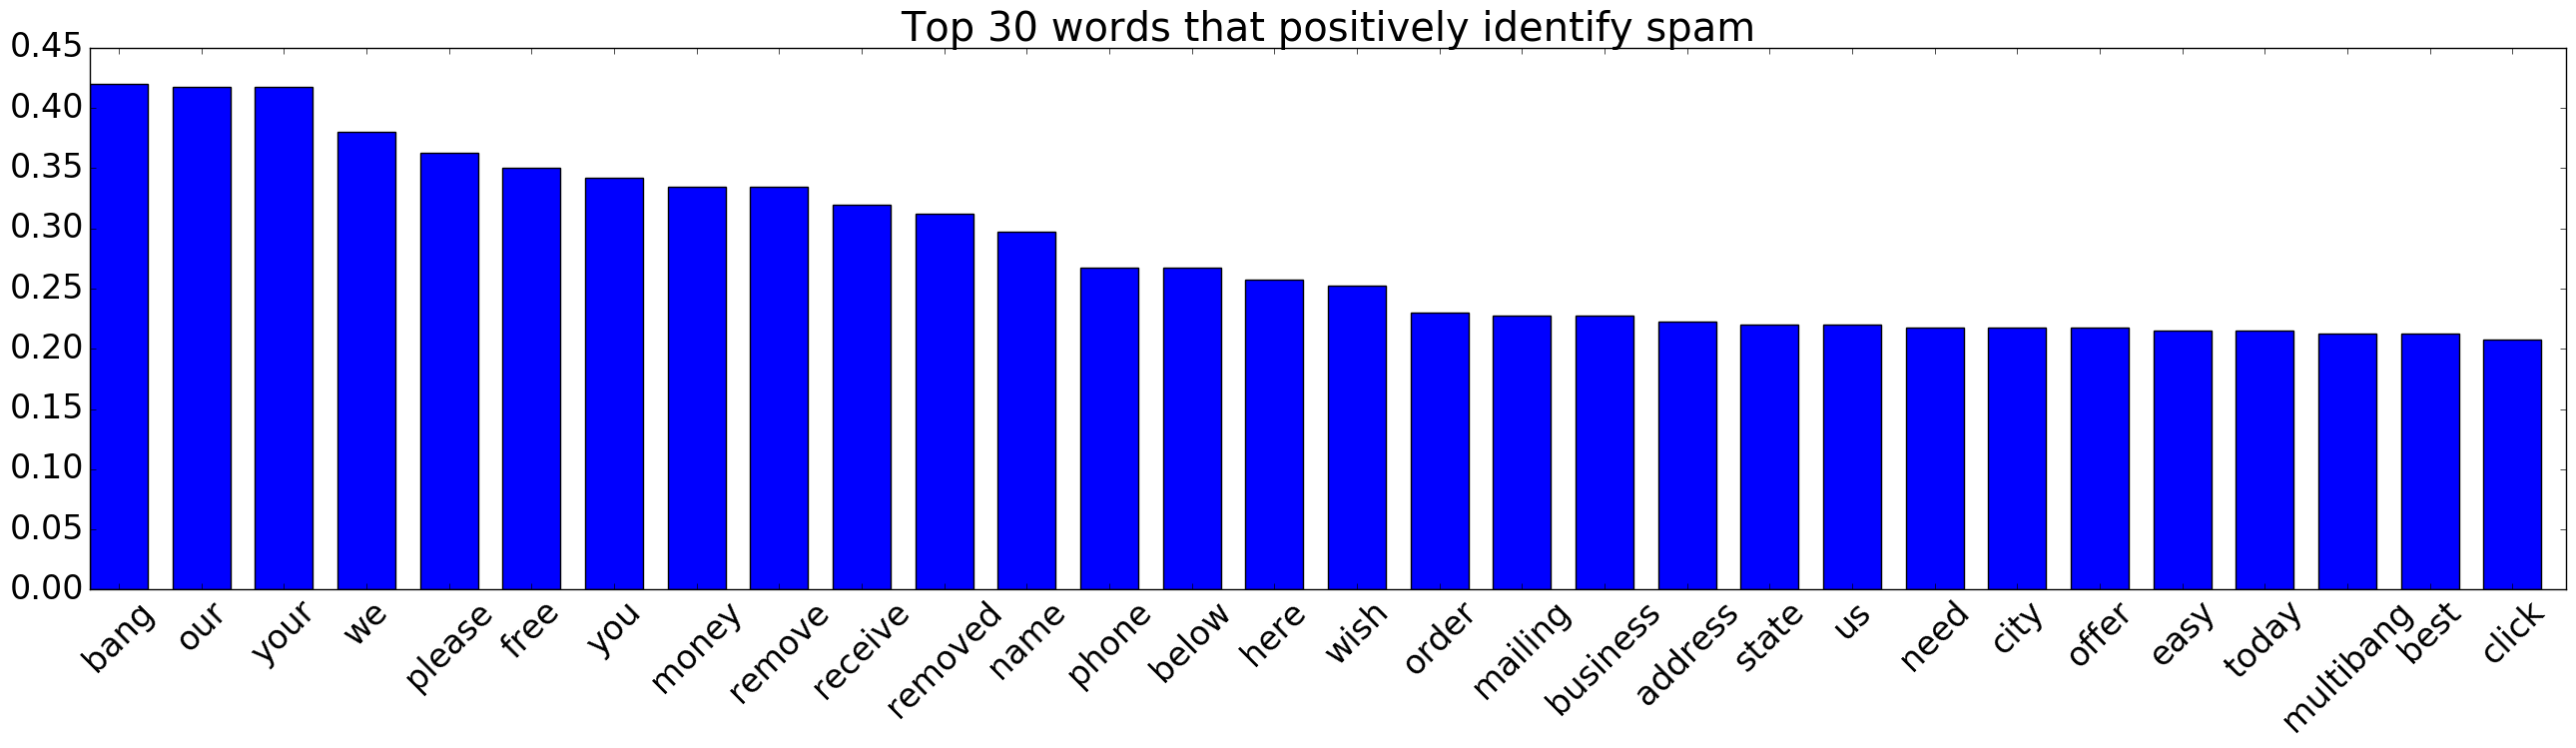

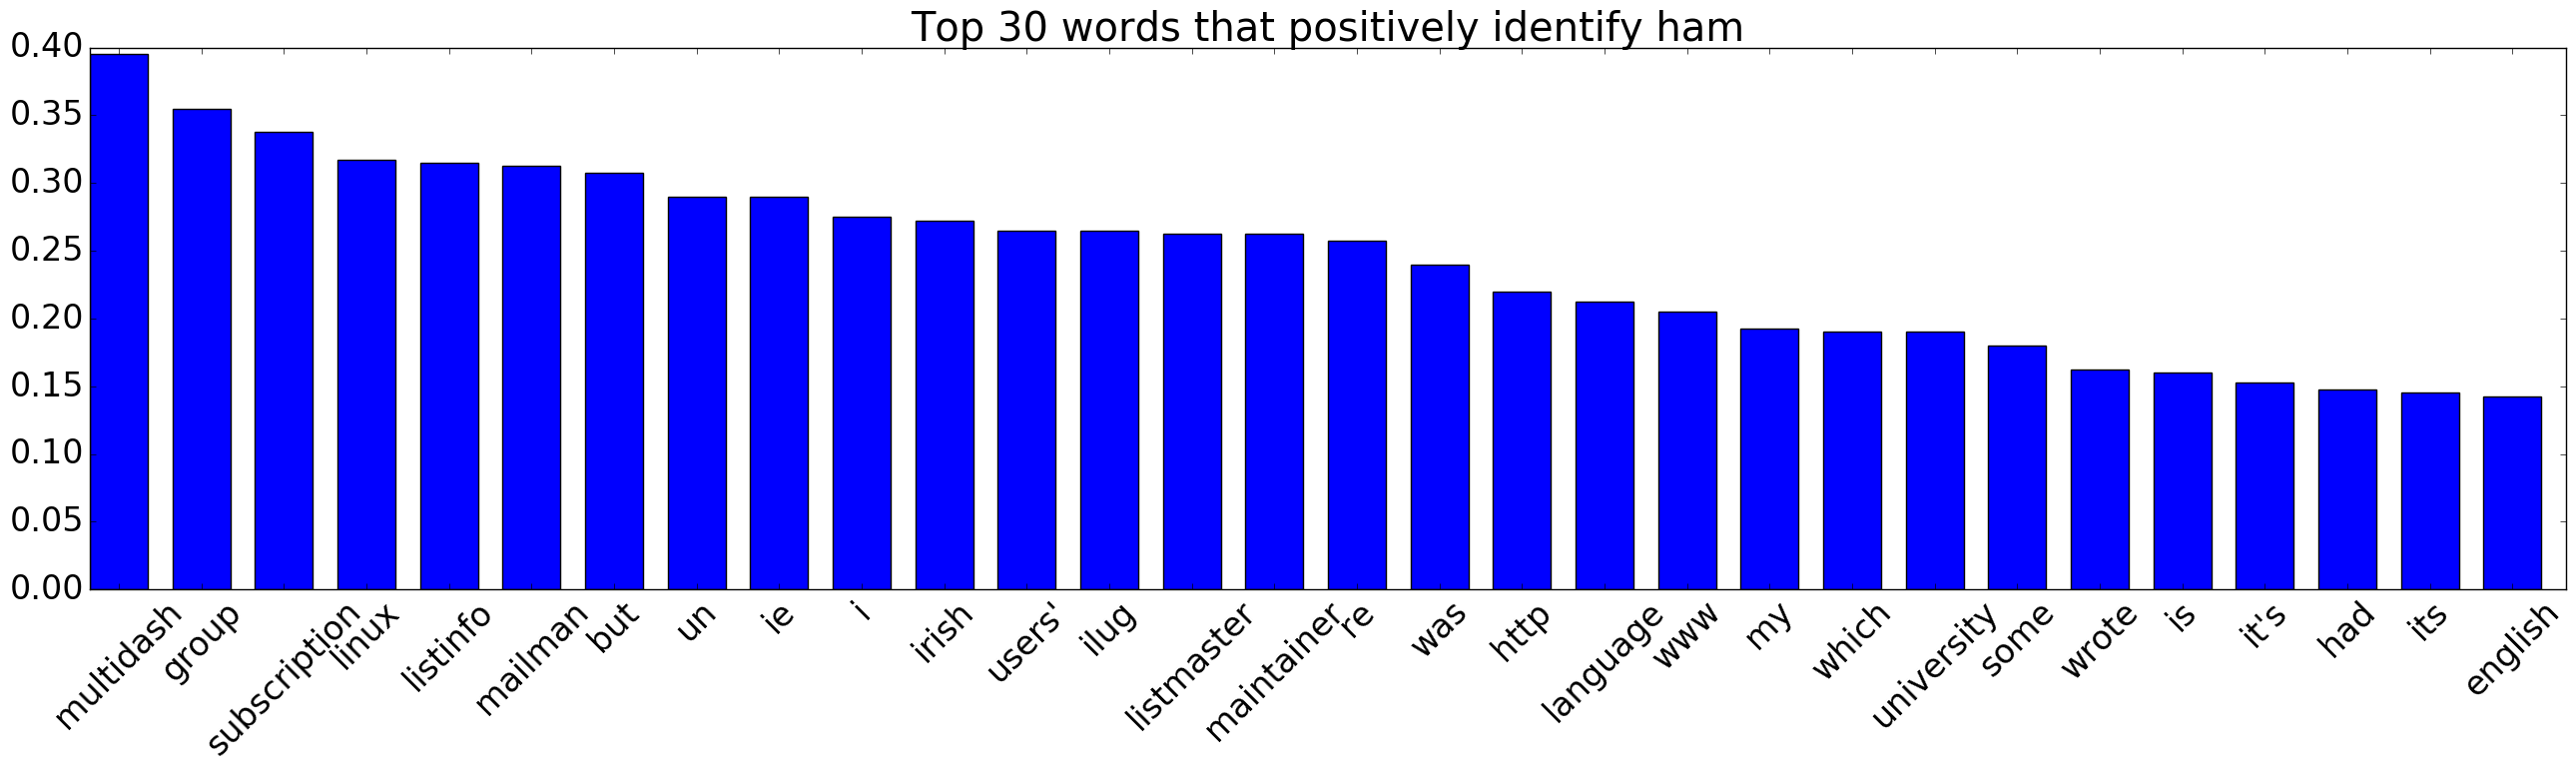

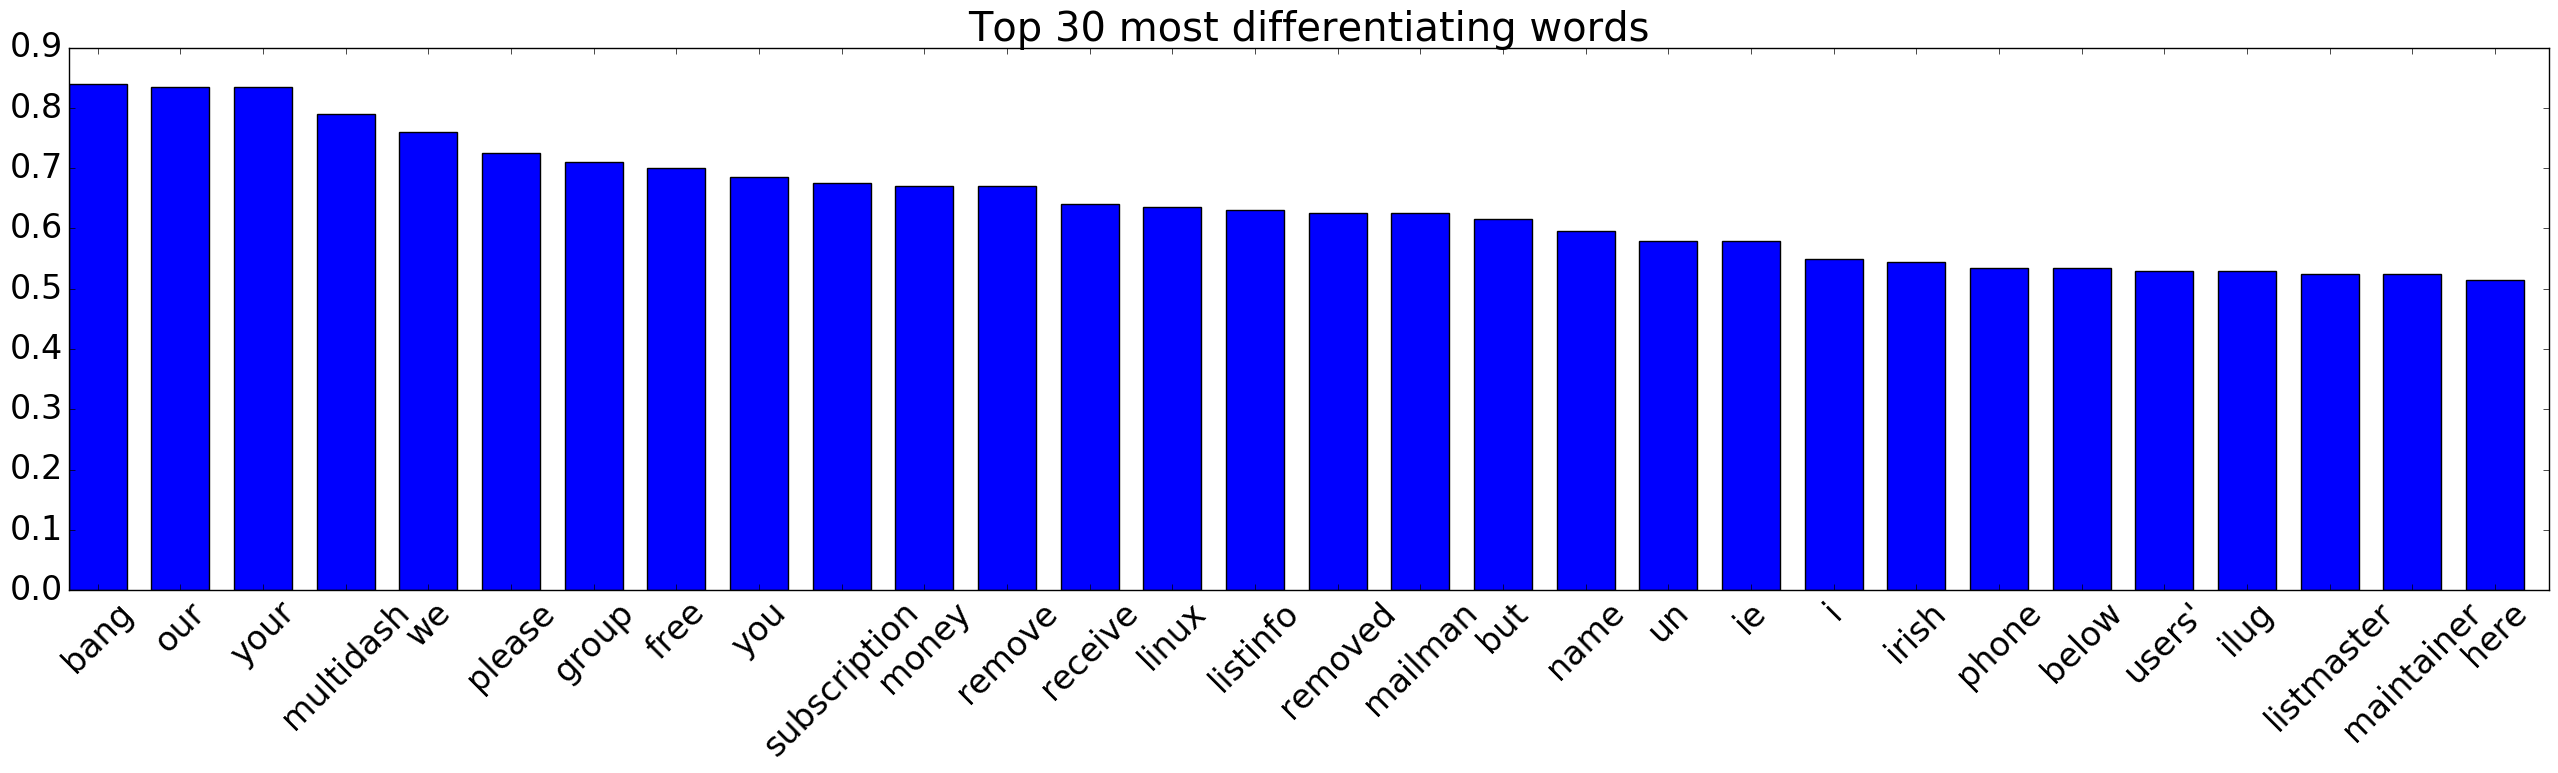

In [769]:
mostIdentifying = differenceDistributions( 30, advancedPreprocess )

In [773]:
featureWords = getMostProbable( mostIdentifying, 1000 ).keys()

def simpleFeatureExtract( email ):
    return [ w in email for w in featureWords ]

clf = BernoulliNB()
X, y = getData( simpleFeatureExtract, advancedPreprocess )
scores = cross_val_score( clf, X, y, cv=5 )
print('Accuracy: %0.3f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

Accuracy: 0.874 (+/- 0.08)


## Dimensionality Reduction

In [488]:
def idealGridSize( n ):
    bound = 1 + int(np.ceil(np.sqrt( n )))
    size = (1, n)
    for i in range( 1, bound ):
        if not n % i:
            j = n // i
            size = (i, j)
    return size

def showScatters( scatters, labels, orientation = 'horizontal' ):
    l = len( scatters )
    if orientation == 'vertical':
        ncols, nrows = idealGridSize( l )
    else:
        nrows, ncols = idealGridSize( l )
        
    fig = plt.figure()
    for plotnum in range( ncols * nrows ):
        ax = fig.add_subplot( nrows, ncols, plotnum + 1 )
        ax.axis( 'off' )
        xs, ys, features = scatters[ plotnum ]
        ax.set_title( "f%i f%i" % features )
        ax.scatter( xs, ys, 5, color=labels )
    fig.tight_layout()
    plt.show()

def getFeatureScatters( X, n ):
    
    scatters = []
    
    for f1, f2 in combinations( range(1, n), 2 ):
        scatters.append(( X[ :, f1 ], X[ :, f2 ], (f1, f2) ))
        clear_output( wait = True )
        
    return scatters

In [454]:
help( PCA )

Help on class PCA in module sklearn.decomposition.pca:

class PCA(sklearn.decomposition.base._BasePCA)
 |  Principal component analysis (PCA)
 |  
 |  Linear dimensionality reduction using Singular Value Decomposition of the
 |  data to project it to a lower dimensional space.
 |  
 |  It uses the LAPACK implementation of the full SVD or a randomized truncated
 |  SVD by the method of Halko et al. 2009, depending on the shape of the input
 |  data and the number of components to extract.
 |  
 |  It can also use the scipy.sparse.linalg ARPACK implementation of the
 |  truncated SVD.
 |  
 |  Notice that this class does not support sparse input. See
 |  :class:`TruncatedSVD` for an alternative with sparse data.
 |  
 |  Read more in the :ref:`User Guide <PCA>`.
 |  
 |  Parameters
 |  ----------
 |  n_components : int, float, None or string
 |      Number of components to keep.
 |      if n_components is not set all components are kept::
 |  
 |          n_components == min(n_samples, n

In [490]:
spamEmails = getEmails( 'spam' ) 
hamEmails = getEmails( 'ham' )
emails = spamEmails + hamEmails

vectorizer = CountVectorizer( min_df = 1,
                              preprocessor = advancedPreprocess )
dtm = vectorizer.fit_transform( spamEmails )

# svd = TruncatedSVD( 50, algorithm = 'arpack' )
# dtm_svd = svd.fit_transform( dtm )

# pca = PCA( n_components = 10, svd_solver = 'full' )
# pca.fit( dtm_svd )

# T = [ vectorizer, svd, pca ]
# X = reduce( lambda x, y : y.transform(x), T, emails )
# # X = pca.transform(svd.transform(vectorizer.transform(emails)))

# labels = ['r'] * len(spamEmails) + ['b'] * len(hamEmails)
# showScatters( getFeatureScatters( X, pca.n_components_ ), labels )

In [16]:
with open( 'vocab.txt' ) as f:
    vocab = sum( [ l.split() for l in f.readlines() ], [] )

vectorizer = CountVectorizer( binary = True, vocabulary = vocab, preprocessor = advancedPreprocess )
spamEmails = getEmails( 'spam' ) 
hamEmails = getEmails( 'ham' )
emails = spamEmails + hamEmails
X = vectorizer.transform( emails )
y = len( spamEmails ) * [0] + len( hamEmails ) * [1]
clf = MultinomialNB()
scores = cross_val_score( clf, X, y, cv=5 )
print("Accuracy: %0.3f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.934 (+/- 0.05)


In [795]:
spamEmails = getEmails( 'spam' ) 
hamEmails = getEmails( 'ham' )
emails = spamEmails + hamEmails
vectorizer = CountVectorizer( binary = True, preprocessor = advancedPreprocess )
vectorizer.fit( spamEmails )
X = vectorizer.transform( emails )
y = len( spamEmails ) * [0] + len( hamEmails ) * [1]
clf = MultinomialNB()
scores = cross_val_score( clf, X, y, cv=5 )
print("Accuracy: %0.3f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.934 (+/- 0.05)
